In [6]:
import sys
sys.path.insert(0, "..")

from base_f import daily_climatology, spatial_avg_daily_input, spatial_stats_daily_input, compute_anomalies, create_it_matrix
from cross_validation_f import SVR_nested_CV_gridsearch, SVR_PCA_nested_CV_gridsearch
from cross_validation_f import evaluate_prediction, plot_prediction, plot_anomalies
from cross_validation_f import nested_CV_PCA_SVR_predict, nested_CV_SVR_predict
from cross_validation_f import classic_CV_PCA_SVR_predict, classic_CV_SVR_predict


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA


import matplotlib.pyplot as plt
import os
import pdb
import seaborn as sns

In [2]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [3]:
path=r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\Documents\conda\daily_input\\'
daily_input = pd.read_csv(path+nb_name[:-6]+'.csv', index_col=0, parse_dates=True)

In [7]:
daily_input

,T,T5,T25,T75,T95,E,E5,E25,E75,E95,...,P5,P25,P75,P95,S,S5,S25,S75,S95,Q
1979-01-01,265.918031,261.222465,263.993230,268.324627,269.343123,0.411576,0.194385,0.299879,0.512662,0.707708,...,5.803930e-02,9.876383e-02,0.309173,0.692008,NaN,NaN,NaN,NaN,NaN,NaN
1979-01-02,257.772814,251.264621,255.439761,260.349301,261.912248,0.531092,0.115208,0.303008,0.726450,1.044784,...,4.285155e-02,6.616075e-02,0.164523,0.438847,NaN,NaN,NaN,NaN,NaN,NaN
1979-01-03,258.547721,251.850343,255.613769,261.278212,263.326783,0.306844,0.047683,0.138478,0.442030,0.680670,...,1.326625e-01,2.325948e-01,0.730420,1.286573,0.372549,0.0,0.0,1.0,1.0,NaN
1979-01-04,259.579312,253.386514,256.425892,262.510150,263.741547,0.160395,-0.018700,0.078187,0.216257,0.377881,...,8.302348e-02,1.591317e-01,0.349544,0.566182,0.647059,0.0,0.0,1.0,2.0,NaN
1979-01-05,261.010850,254.625395,258.116074,264.029952,264.928466,0.122560,0.014397,0.069238,0.181916,0.210533,...,9.336270e-05,2.816389e-04,0.002362,0.004502,0.568627,0.0,0.0,1.0,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,274.512384,270.462722,271.990406,276.154564,279.052326,0.577883,0.333127,0.405124,0.681003,0.887355,...,1.914923e-01,2.907917e-01,1.528631,2.752204,84.725490,0.0,0.0,152.5,270.5,73.852
2019-12-28,273.330257,269.169505,270.697487,275.545965,278.456703,0.781328,0.373545,0.550027,0.937609,1.366413,...,6.288857e-04,1.596905e-03,0.004189,0.008967,84.372549,0.0,0.0,152.0,270.0,58.781
2019-12-29,271.959329,267.243056,269.344837,274.201717,277.175930,0.953996,0.284958,0.775192,1.151139,1.585539,...,0.000000e+00,0.000000e+00,0.000011,0.000120,84.235294,0.0,0.0,152.0,269.5,49.304
2019-12-30,272.619069,267.937788,269.854226,274.683593,277.407277,0.124352,-0.208734,-0.064813,0.265457,0.379312,...,0.000000e+00,4.238357e-07,0.000087,0.000622,84.117647,0.0,0.0,152.0,269.5,62.345


In [4]:
t_unit=10

#define the possible parameters value (where Gridsearch is applied)

C_range=np.logspace(-1, 0, 7)
epsilon_range=np.logspace(-3, -2, 4)
#n_range = [17, 50, 200]
components_range = [5*4*36]
#do not enlarge t_range for now
t_range=[36]
t_length=t_range[0]
n_splits=4
test_size=730

Fitting 1 folds for each of 28 candidates, totalling 28 fits
Fitting 1 folds for each of 28 candidates, totalling 28 fits
Fitting 1 folds for each of 28 candidates, totalling 28 fits
Fitting 1 folds for each of 28 candidates, totalling 28 fits

C=1.0
eps=0.004641588833612777


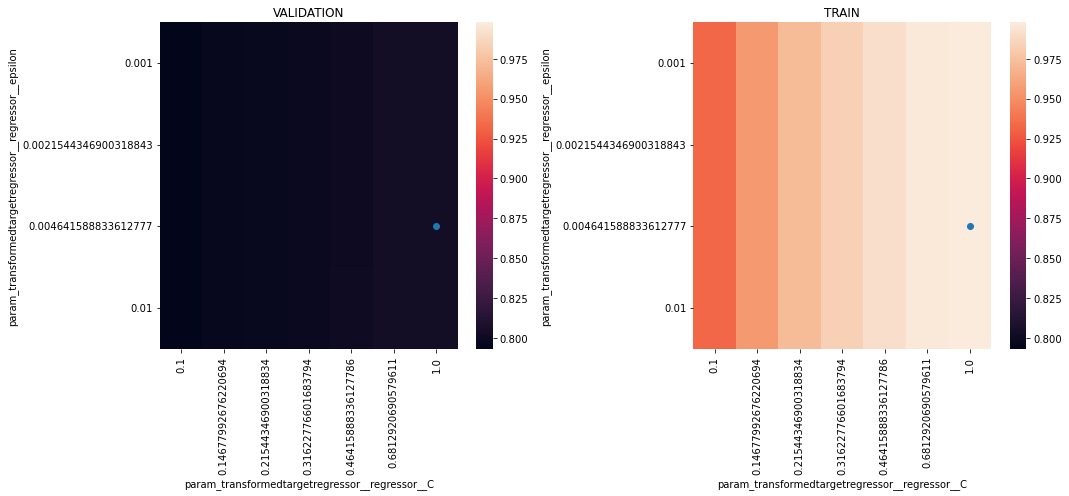

In [7]:
C, eps = SVR_nested_CV_gridsearch(daily_input, C_range,epsilon_range, t_range,t_unit,n_splits,test_size)
print(f'C={C}')
print(f'eps={eps}')

In [11]:
C_range=np.logspace(0, 1, 3)
epsilon_range=np.logspace(-3, -2, 4)

Fitting 1 folds for each of 12 candidates, totalling 12 fits
Fitting 1 folds for each of 12 candidates, totalling 12 fits
Fitting 1 folds for each of 12 candidates, totalling 12 fits
Fitting 1 folds for each of 12 candidates, totalling 12 fits

C=10.0
eps=0.01


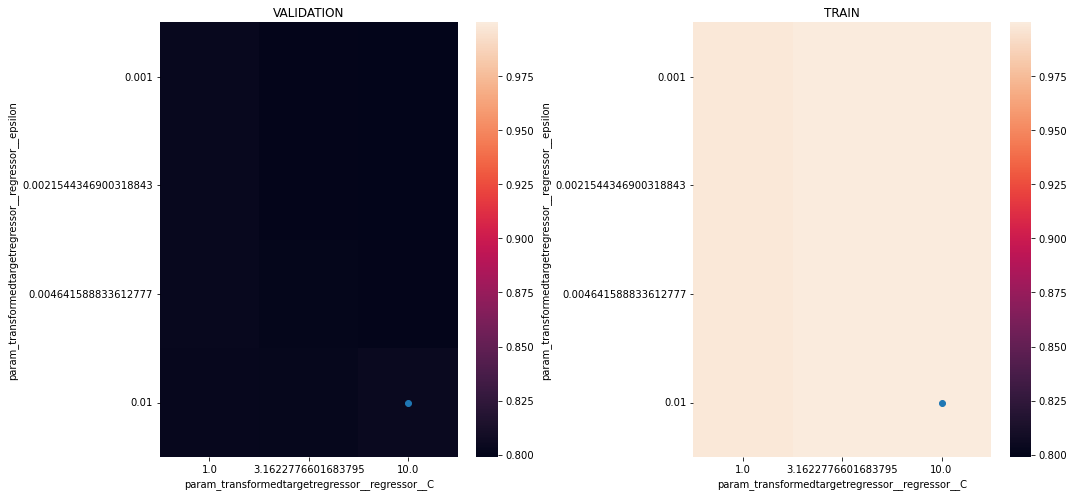

In [12]:
C, eps = SVR_nested_CV_gridsearch(daily_input, C_range,epsilon_range, t_range,t_unit,n_splits,test_size)
print(f'C={C}')
print(f'eps={eps}')

In [13]:
C_range=np.logspace(1, 3, 5)
epsilon_range=np.logspace(-2, -0.5, 5)

Fitting 1 folds for each of 25 candidates, totalling 25 fits
Fitting 1 folds for each of 25 candidates, totalling 25 fits
Fitting 1 folds for each of 25 candidates, totalling 25 fits
Fitting 1 folds for each of 25 candidates, totalling 25 fits

C=10.0
eps=0.023713737056616554


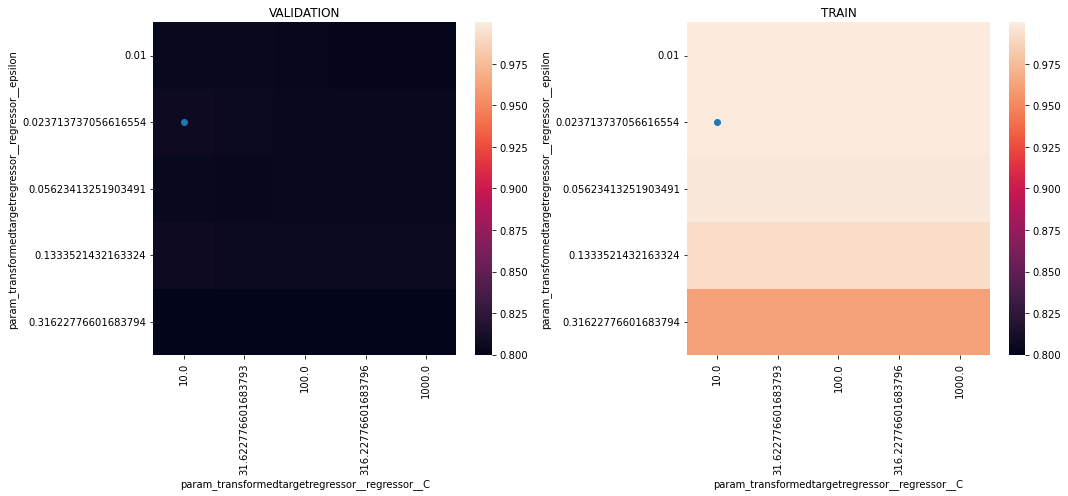

In [14]:
C, eps = SVR_nested_CV_gridsearch(daily_input, C_range,epsilon_range, t_range,t_unit,n_splits,test_size)
print(f'C={C}')
print(f'eps={eps}')

In [8]:
C=10.0
eps=0.023713737056616554

In [9]:
radius_for_ensemble = 1
predictions = nested_CV_SVR_predict(daily_input, C, eps, t_length,t_unit, n_splits, test_size, radius_for_ensemble)

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

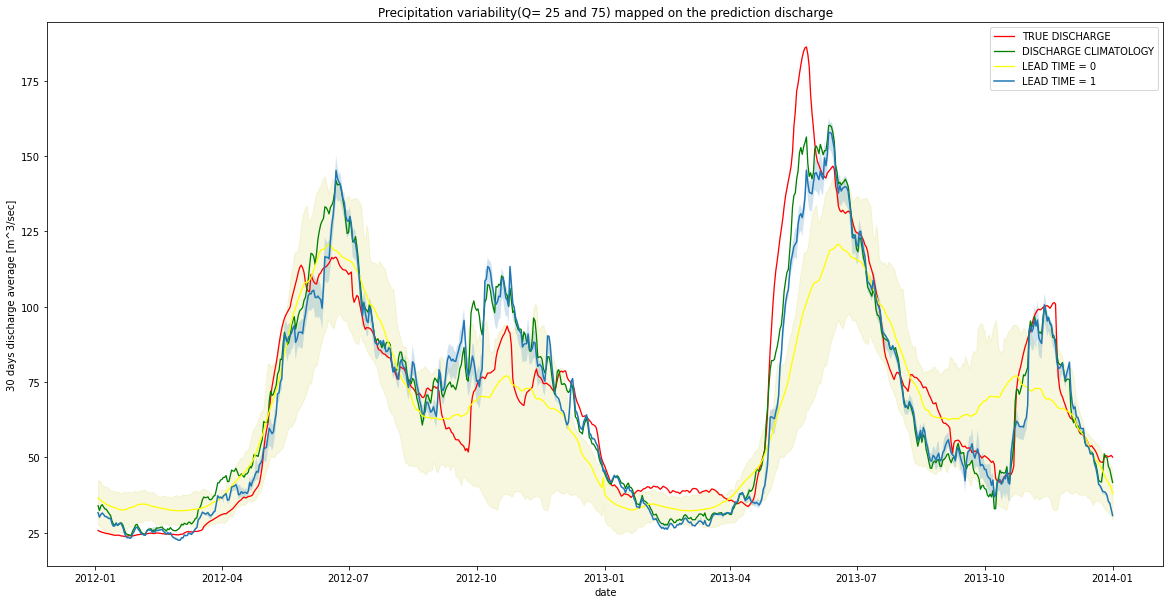

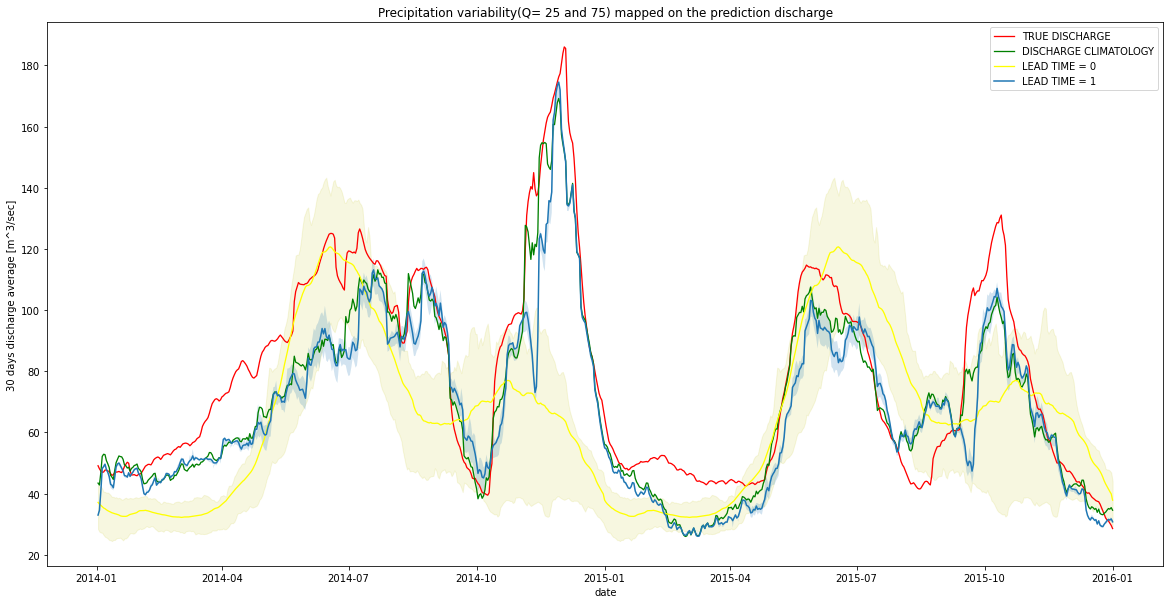

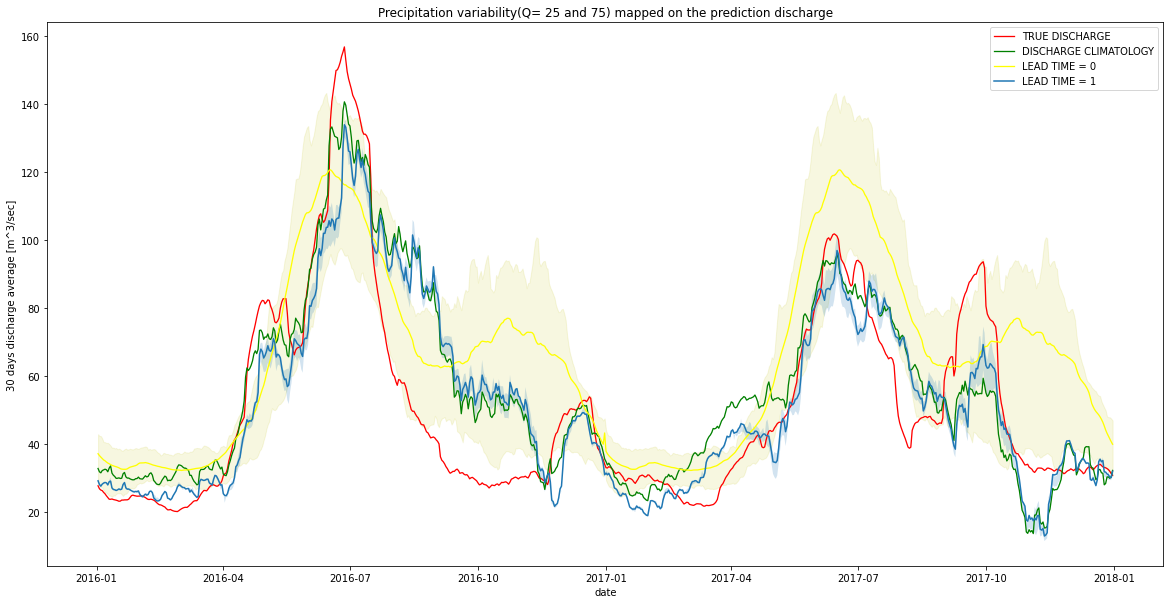

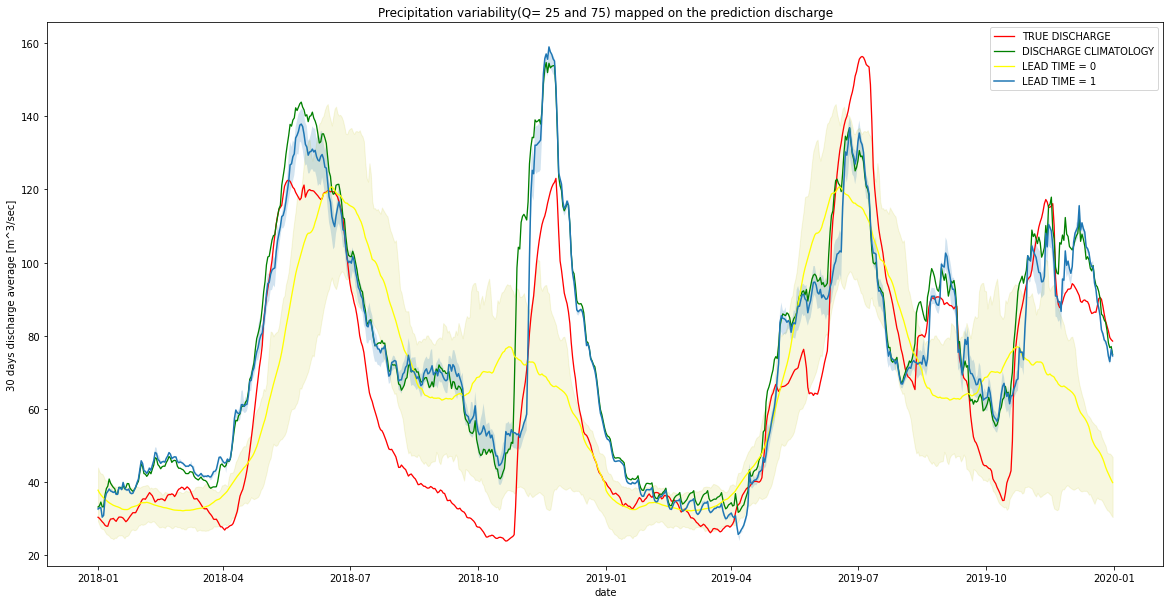

In [10]:
#predictions=pd.read_csv('tial.csv',date_parser=True)
plot_prediction(predictions)


measured runoff             1.000000
runoff climatology          0.492197
runoff_clim_25              0.093408
runoff_clim_75              0.282818
model output                0.806885
output 1 month lead time    0.773412
output 2 month lead time    0.662139
output 3 month lead time    0.477490
output 4 month lead time    0.308549
output 5 month lead time    0.240302
dtype: float64

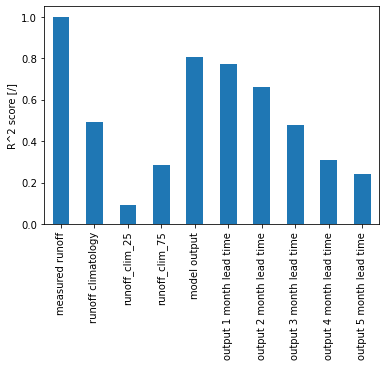

In [11]:
evaluate_prediction(predictions)

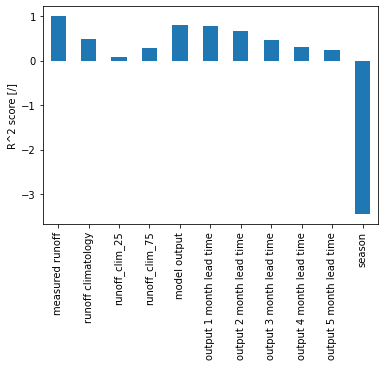

In [12]:
from cross_validation_f import evaluate_class, evaluate_class_season
clas=evaluate_class_season(predictions)
clas.index=np.repeat(nb_name[:-6],4)
clas.to_csv('class_res.csv', mode='a', header=False)

r=pd.DataFrame(evaluate_prediction(predictions)).transpose()
r['STAT_CODE']=(nb_name[:-6])
r.index=r.STAT_CODE
r.drop(columns=['season','runoff_clim_25','runoff_clim_75','STAT_CODE'],inplace=True)
r.to_csv('r_res.csv',mode='a',header=False)

In [16]:
r

,measured runoff,runoff climatology,model output,output 1 month lead time,output 2 month lead time,output 3 month lead time,output 4 month lead time,output 5 month lead time
STAT_CODE,,,,,,,,
ADO_DSC_CH07_0006,1.0,0.492197,0.806885,0.773412,0.662139,0.47749,0.308549,0.240302


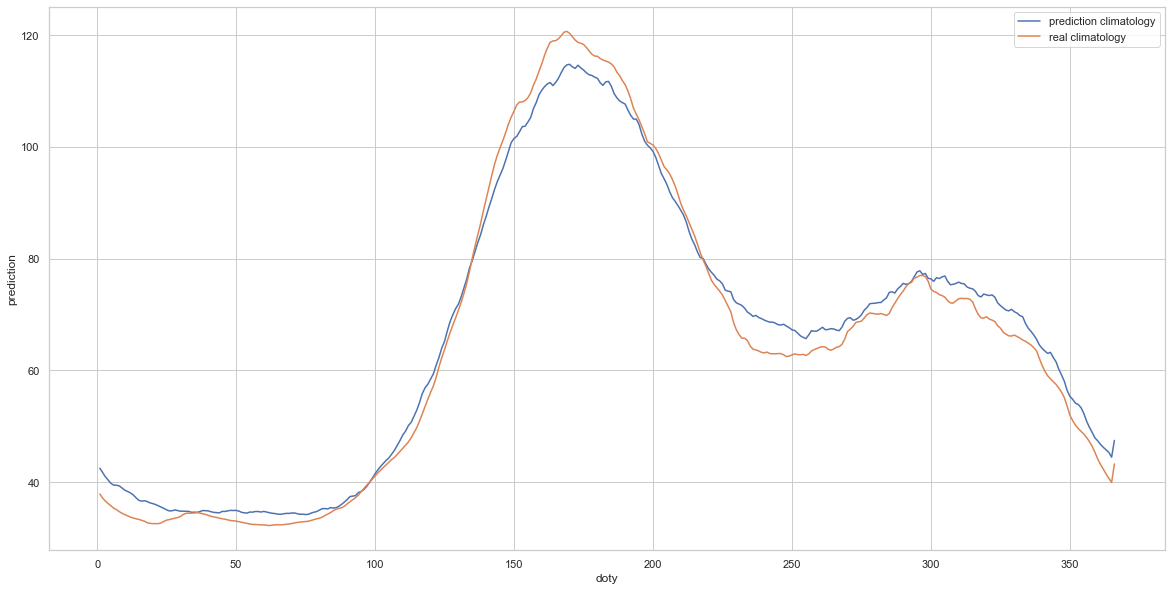

In [13]:
predictions_for_clim = classic_CV_SVR_predict(daily_input, C, eps, t_length,t_unit, n_splits)
climatologies =predictions_for_clim.groupby(by=predictions_for_clim.index.day_of_year).mean().loc[:,['prediction','true_runoff']]
climatologies['doty']=climatologies.index

sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies,x='doty',y='true_runoff',label='real climatology')
plt.legend()

from db_insert import insert
insert(nb_name[:-6],predictions_for_clim)

In [14]:
##develop model savior

from sklearn.svm import SVR, LinearSVR
from base_f import create_it_matrix
from joblib import dump, load

it_matrix=create_it_matrix(daily_input,t_length,t_unit).astype('float32')

X = it_matrix.drop(columns='Q')
y = it_matrix['Q']
svr_estimator = SVR(kernel='rbf', gamma='scale', cache_size=15000,C=C,epsilon=eps)

svr_estimator = make_pipeline(StandardScaler(),
                              TransformedTargetRegressor(regressor=svr_estimator, transformer=StandardScaler()))

svr_estimator.fit(X, y)

path='models/'+nb_name[:-6]+'.joblib'

dump(svr_estimator, path)

['models/ADO_DSC_CH07_0006.joblib']